# MFM simulations

Phase shift of Magnetic Force Microscopy cantilever
\begin{equation}
    \Delta \phi = \frac{Q\mu_0}{k} \left( q \frac{\partial {\bf H}_{sz}}{\partial z} + {\bf M}_t \cdot \frac{\partial^2{\bf H}_{s}}{\partial z^2} \right). \label{Eq:C7:MFM_phase_Full}
\end{equation}

where (I will assume the tip is a delta function for now),
$Q$ is the quality factor of the cantilever,
$k$ is the spring constant of the cantilever,
$q$ is the magnetic monopole moment of the tip,
${\bf M}_t$ is the magnetic dipole moment of the tip and,
${\bf H}_{sz}$ is the magnetic field due to the sample.


### Importing Packages

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import matplotlib.pyplot as plt
import mag2exp
import matplotlib.colors

### Magnetisation data

Perform micromagnetic simulation or load from file.

In [262]:
region = df.Region(p1=(-50e-9, -50e-9, -50e-9), p2=(50e-9, 50e-9, 50e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=8.78e-12)
               + mm.DMI(D=3e-3, crystalclass='T') #1.58e-3
               #+ mm.UniaxialAnisotropy(K=0.8e6, u=(0, 0, 1))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 10e4)))

In [263]:
mesh.n

(20, 20, 20)

In [264]:
Ms = 384e3

    
def Ms_fun(pos):
    """Function to set magnitude of magnetisation: zero above the sample,
    Ms inside sample.

    Sample thickness is 50nm.

    """
    x, y, z = pos
    if (z < 0):
        return Ms
    else:
        return 0
    
def m_t_q(pos):
    """
    Function to make a tripple q structure with a period of 50 nm
    
    """
    q = 2*np.pi/(50e-9)
    x, y, z = pos
    
    m_x = 1*(np.sqrt(3)/3)*(- (np.sqrt(3)/2)*np.sin(q*(-0.5*x+np.sqrt(3)*y/2)) 
                            + (np.sqrt(3)/2)*np.sin(q*(-0.5*x-np.sqrt(3)*y/2)))
    m_y = 1*(np.sqrt(3)/3)*(np.sin(q*(x)) 
                            - (1/2)*np.sin(q*(-0.5*x+np.sqrt(3)*y/2)) 
                            - (1/2)*np.sin(q*(-0.5*x-np.sqrt(3)*y/2)) )
    m_z = (1+ 1*(np.sqrt(3)/3)*(-np.cos(q*(x))
                                - np.cos(q*(-0.5*x+np.sqrt(3)*y/2))
                                - np.cos(q*(-0.5*x-np.sqrt(3)*y/2))))
    return (m_x, m_y, m_z)

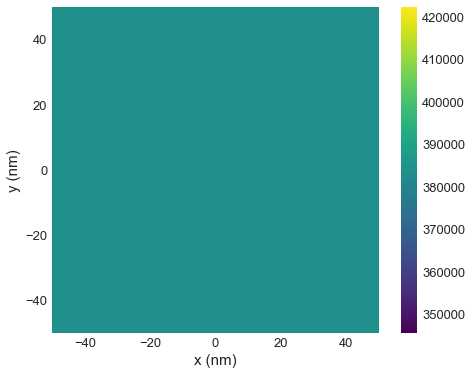

In [265]:
system.m = df.Field(mesh, dim=3, value=(0,0,1), norm=Ms)
system.m.z.plane(z=-5e-9).mpl.plot()

In [266]:
demag = oc.compute(system.energy.demag.effective_field, system)

Running OOMMF (DockerOOMMFRunner) [2021/07/29 18:21]... (3.0 s)


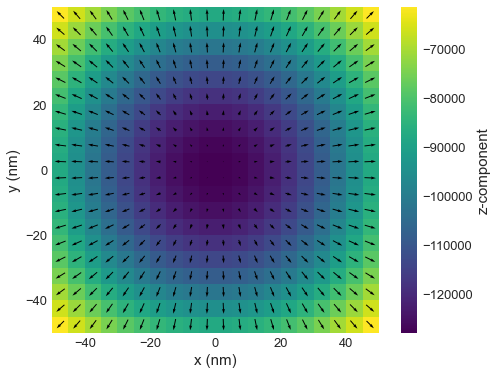

In [267]:
demag.plane(z=0e-9).mpl.plot()

\begin{array}
    H &= \frac{1}{\mu_0}B - M \\
     & = \frac{1}{\mu_0} \nabla \times A - M \\
\end{array}

In [270]:
m_pad= system.m.pad(pad_width={'x': (0, 2*system.m.mesh.n[0]+1),
                               'y': (0, 2*system.m.mesh.n[1]+1),
                               'z': (0, 2*system.m.mesh.n[2]+1)}, mode='constant')
mft = m_pad.fft3
k = df.Field(mesh=mft.mesh, dim=3, value=lambda x: x)
k2 = k @ k + 1e-10
demag2_ft = -mft + ((1/(1)) * k & (mft & k) / k2)
demag2 = demag2_ft.ifft3.real

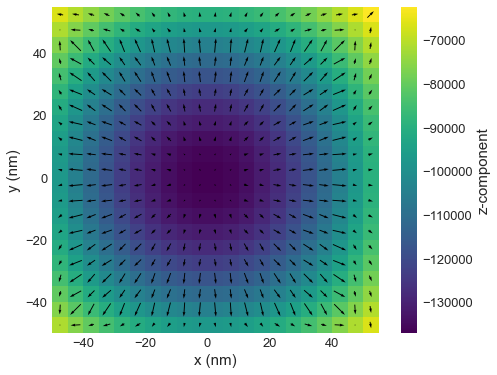

In [271]:
demag2[region].plane(z=0e-9).mpl.plot()

In [ ]:
system.m.plane('x').mpl()

In [ ]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

In [ ]:
system.m.z.plane(z=5e-9).mpl()

### MFM Calculation

Phase shift of Magnetic Force Microscopy cantilever
\begin{equation}
    \Delta \phi = \frac{Q\mu_0}{k} \left( q \frac{\partial {\bf H}_{sz}}{\partial z} + {\bf M}_t \cdot \frac{\partial^2{\bf H}_{s}}{\partial z^2} \right). \label{Eq:C7:MFM_phase_Full}
\end{equation}

where (I will assume the tip is a delta function for now),
$Q$ is the quality factor of the cantilever,
$k$ is the spring constant of the cantilever,
$q$ is the magnetic monopole moment of the tip,
${\bf M}_t$ is the magnetic dipole moment of the tip and,
${\bf H}_{sz}$ is the magnetic field due to the sample.


In [ ]:
phase = mag2exp.mfm.phase_shift(system, Q=650, k=3, tip_m=(0,0,1e-13))

In [ ]:
gf_3d = mag2exp.util.gaussian_filter(phase, fwhm=[15e-9, 15e-9, 0])
gf_3d.plane(z=50e-9).mpl()

In [ ]:
phase.plane(z=50e-9).mpl_scalar()

Calculate stray field (does this give the stray field when an external field is also applied?)

Need to think about convolutions with a tip function? And proper normalisation!

In [ ]:
conv_mag2exp = mag2exp.util.gaussian_filter(phase.plane(z=50e-9), fwhm=[15e-9, 15e-9])

In [ ]:
(conv_mag2exp - gf_3d.plane(z=50e-9)).mpl()

In [ ]:
phase = mag2exp.mfm.phase_shift(system, Q=650, k=3, tip_m=(0,0,1e-13), fwhm=(15e-9, 15e-9, 0))

In [ ]:
phase.plane(z=50e-9).mpl_scalar()

In [ ]:
boundaries = sorted(phase.array.flat)[:: len(phase.array.flat)//100][:-1] + [np.max(phase.array.flat)]
@df.interact(x=system.m.mesh.slider('x'))
def plot(x):
    conv_mag2exp = phase.plane(x=x)
    conv_mag2exp.mpl_scalar(norm=matplotlib.colors.BoundaryNorm(boundaries=boundaries, ncolors=256))

In [ ]:
region = df.Region(p1=(0,0,5e-9), p2=(150e-9,150e-9,100e-9))
sub_phase = phase[region]

boundaries = sorted(sub_phase.array.flat)[:: len(sub_phase.array.flat)//100][:-1] + [np.max(sub_phase.array.flat)]
@df.interact(x=system.m.mesh.slider('x'))
def plot(x):
    conv_mag2exp = sub_phase.plane(x=x)
    conv_mag2exp.mpl_scalar(norm=matplotlib.colors.BoundaryNorm(boundaries=boundaries, ncolors=256))